In [ ]:
import numpy as np
import pandas as pd
from osgeo import gdal
import rasterio as rio
from rasterio import features
from rasterio.features import rasterize
import rasterio.plot as rioplt
import matplotlib.pyplot as plt
import glob
import os
import math
import geopandas as gpd
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


## PlanetScope + SimCLR

In [2]:
def simple_burnt_validation(prediction, labels,out_dir=None, postive_values=1, sampling = False):
    '''
    prediction: path of the prediction
    labels: path of the shapefile indicating the binary result
    sampling: default is false, if the ratio larger than 2 or smaller than 0.5, will be changed to True defautly
    '''
    rs_prediction = rio.open(prediction)
    rs_pred_prj = rs_prediction.crs.data['init']
    rs_pred_arr = rs_prediction.read().astype(np.int16)
    vector = gpd.read_file(labels)
    
    vector_rpj = vector.to_crs(rs_pred_prj)
    geom = [shapes for shapes in vector_rpj.geometry]
    rasterized_label = features.rasterize(geom,
                            out_shape = rs_prediction.shape,
                            fill = 0,
                            out = None,
                            transform = rs_prediction.transform,
                            all_touched = True,
                            default_value = 1,
                            dtype = None)
    # Plot raster
    fig, ax = plt.subplots(1,2, figsize = (20, 10))
    rioplt.show(rasterized_label, ax = ax[0])
    if postive_values:
        rioplt.show(rs_pred_arr, ax = ax[1])
    else:
        rioplt.show(1-rs_pred_arr, ax = ax[1])
    ax[0].axis("off")
    ax[0].set_title("Label")
    ax[1].axis("off")
    ax[1].set_title("Prediction")

    if type(out_dir) == str:
        plt.savefig(out_dir,dpi=300)
    else:
        plt.show()
    #check the ratio of the postive vs negative labels
    num_pos_label = np.sum(rasterized_label)
    num_neg_label = np.sum(1-rasterized_label)
    ratio = num_pos_label/num_neg_label
    if ratio < 0.5 or ratio>2:
        sampling = True
    
    #randomly downsampling the major label to fit the minor label
    if sampling:
        
        if num_pos_label < num_neg_label: #number of negative labels > postive
            majority_row_col = np.argwhere(rasterized_label==0)
            minority_row_col = np.argwhere(rasterized_label==1)
            minor_num = num_pos_label
            major_num = num_neg_label
            major_label = 0
        else:
            majority_row_col = np.argwhere(rasterized_label==1)
            minority_row_col = np.argwhere(rasterized_label==0)
            minor_num = num_neg_label
            major_num = num_pos_label
            major_label = 1
        
        rand_idx = np.random.randint(0, high=major_num, size=minor_num, dtype=int)
        sampled_major_row_col = majority_row_col[rand_idx,:]

        df_label = pd.DataFrame(data = {"row": np.concatenate((sampled_major_row_col[:,0],minority_row_col[:,0]),axis = 0),
                                    "col":np.concatenate((sampled_major_row_col[:,1],minority_row_col[:,1]),axis = 0),
                                    "label": np.concatenate((np.full((minor_num,),major_label),np.full((minor_num,),1-major_label)),axis = 0)})
        pred_arr = rs_pred_arr[:,df_label.row.values,df_label.col.values].flatten()
        if postive_values:
            df_pred = pd.DataFrame(data = {"row": df_label.row.values,
                                            "col": df_label.col.values,
                                            "label": pred_arr})
        else:
            df_pred = pd.DataFrame(data = {"row": df_label.row.values,
                                            "col": df_label.col.values,
                                            "label": 1-pred_arr})

    #no downsampling, comparing directly
    else:
        neg_label_loc = np.argwhere(rasterized_label==0)
        pos_label_loc = np.argwhere(rasterized_label==1)
        df_label =  pd.DataFrame(data = {"row": np.concatenate((neg_label_loc[:,0],pos_label_loc[:,0]),axis = 0),
                                "col":np.concatenate((neg_label_loc[:,1],pos_label_loc[:,1]),axis = 0),
                                "label": np.concatenate((np.full((neg_label_loc.shape[0],),0),np.full((pos_label_loc.shape[0],),1)),axis = 0)})
        pred_arr = rs_pred_arr[:,df_label.row.values,df_label.col.values].flatten()
        if postive_values:
            df_pred = pd.DataFrame(data = {"row": df_label.row.values,
                                            "col": df_label.col.values,
                                            "label": pred_arr})
        else:
            df_pred = pd.DataFrame(data = {"row": df_label.row.values,
                                            "col": df_label.col.values,
                                            "label": 1-pred_arr})
    
    cm = confusion_matrix(df_label.label.values, df_pred.label.values)

    f1 = f1_score(df_label.label.values, df_pred.label.values)
    precision = precision_score(df_label.label.values, df_pred.label.values)
    recall = recall_score(df_label.label.values, df_pred.label.values)
    accuracy = accuracy_score(df_label.label.values, df_pred.label.values)

    return df_label,df_pred,cm,f1,precision,recall,accuracy

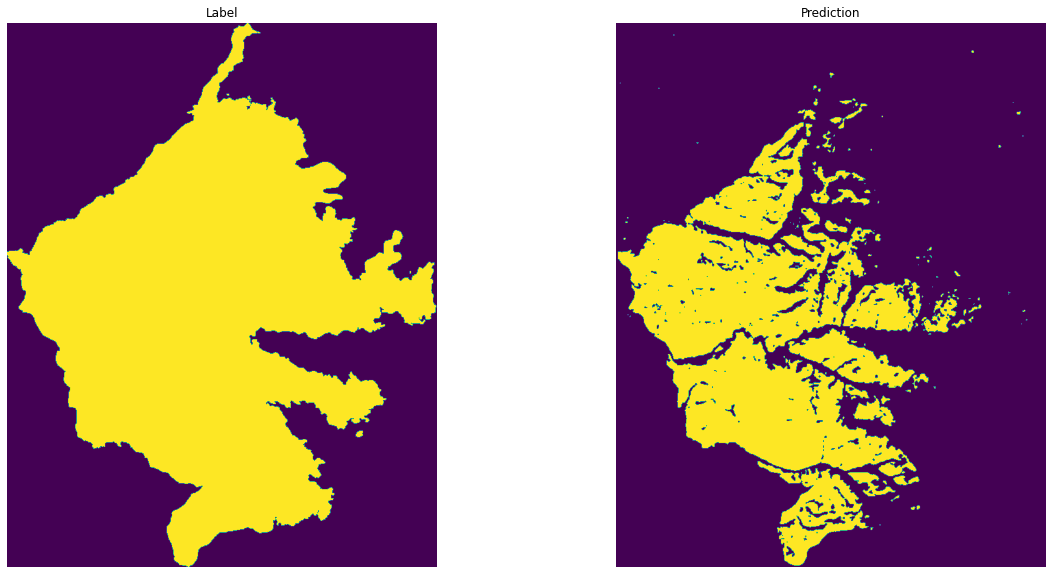

In [3]:
df_label,df_pred,cm,f1,precision,recall,accuracy = simple_burnt_validation("/home/zbc123a/PS_CD_results/Mesa_PS_Stride8_2cluster_kmeans_vector_SR_20180726_20180815.tif", 
                                                                            "/home/zbc123a/wildfire/notebooks/Downstream/Labels/Mesa_Shapefile/fire_parameter/MesaFire.shp", 
                                                                            out_dir = "/home/zbc123a/wildfire/notebooks/Downstream/Figures/PS_2cluster.png",
                                                                            sampling = True)


F1 score: 0.712 
Precision: 0.999 
Recall: 0.553 
Accuracy: 0.776 



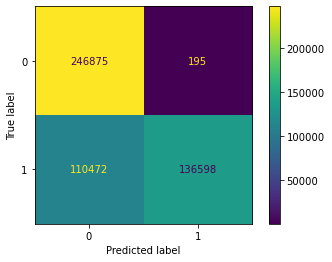

In [29]:
print("F1 score: %.3f \nPrecision: %.3f \nRecall: %.3f \nAccuracy: %.3f \n" %(f1,precision,recall,accuracy))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [23]:
def burnt_label_validation(prediction, severity_labels, pred_dict, out_dir=None, sampling = True):
    '''
    prediction: path of the prediction
    severity_labels: a list of paths of the shapefiles indicating the binary results of the burnt severity
    pred_dict: a dictionary indicate the expert identified class from the kmeans (maybe change later)
    sampling: default is false, if the ratio larger than 2 or smaller than 0.5, will be changed to True defautly
    '''
    #burnt_severity_dict = {"Unburnt": 1, "Active_Crown": 1, "Passive_Crown": 2, "Black_Ash": 3, "White_Ash": 4}
    burnt_severity_dict = {"Unburnt": 3, "Black_Ash": 2, "White_Ash": 1}
    df_metrics = pd.DataFrame(index=["Unburnt", "Black_Ash", "White_Ash"],
                            columns=["Confusion_Matrix","F1_score","Precision","Recall","Accuracy"])

    rs_prediction = rio.open(prediction)
    rs_pred_prj = rs_prediction.crs.data['init']
    

    burnt_list = []
    for shp in severity_labels:
        rs_pred_arr = rs_prediction.read().astype(np.int16)
        shp_name = os.path.basename(shp)[:-4]
        val = burnt_severity_dict[shp_name]
        vector = gpd.read_file(shp)
        
        vector_rpj = vector.to_crs(rs_pred_prj)
        geom = [shapes for shapes in vector_rpj.geometry]
        rasterized_label = features.rasterize(geom,
                                out_shape = rs_prediction.shape,
                                fill = 0,
                                out = None,
                                transform = rs_prediction.transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)
        
        burnt_list.append(rasterized_label*val)

        pred_val = pred_dict[shp_name]
        if pred_val!=0:
            rs_pred_arr[rs_pred_arr!=pred_val] = 0
            rs_pred_arr[rs_pred_arr==pred_val] = 1
        else:
            rs_pred_arr[rs_pred_arr!=pred_val] = -999
            rs_pred_arr[rs_pred_arr==pred_val] = 1
            rs_pred_arr[rs_pred_arr==-999] = 0
        
        # Plot raster
        fig, ax = plt.subplots(1,2, figsize = (20, 10))
        rioplt.show(rasterized_label, ax = ax[0])
        rioplt.show(rs_pred_arr, ax = ax[1])
        
        ax[0].axis("off")

        if len(shp_name.split("_"))>1:
            ax[0].set_title("Annotated " + shp_name.split("_")[0] + " " + shp_name.split("_")[1])
        else:
            ax[0].set_title("Annotated " + shp_name)
        
        ax[1].axis("off")
        if shp_name.split("_")[0] == "Black":
            ax[1].set_title("Prediction (Minor Changes)")
        elif shp_name.split("_")[0] == "White":
            ax[1].set_title("Prediction (Major Changes)")
        else:
            ax[1].set_title("Prediction (No Changes)")
        if type(out_dir) == str:
            plt.savefig(out_dir+"PS_Vector_"+shp_name+".png",dpi=300)
        else:
            plt.show()

        #check the ratio of the postive vs negative labels
        num_pos_label = np.sum(rasterized_label)
        num_neg_label = np.sum(1-rasterized_label)
        
        ratio = num_pos_label/num_neg_label
        if ratio < 0.5 or ratio>2:
            sampling = True
    
        #randomly downsampling the major label to fit the minor label
        if sampling:
            
            if num_pos_label < num_neg_label: #number of negative labels > postive
                majority_row_col = np.argwhere(rasterized_label==0)
                minority_row_col = np.argwhere(rasterized_label==1)
                minor_num = num_pos_label
                major_num = num_neg_label
                major_label = 0
            else:
                majority_row_col = np.argwhere(rasterized_label==1)
                minority_row_col = np.argwhere(rasterized_label==0)
                minor_num = num_neg_label
                major_num = num_pos_label
                major_label = 1
        
            rand_idx = np.random.randint(0, high=major_num, size=minor_num, dtype=int)
            sampled_major_row_col = majority_row_col[rand_idx,:]
    
            df_label = pd.DataFrame(data = {"row": np.concatenate((sampled_major_row_col[:,0],minority_row_col[:,0]),axis = 0),
                                            "col":np.concatenate((sampled_major_row_col[:,1],minority_row_col[:,1]),axis = 0),
                                            "label": np.concatenate((np.full((minor_num,),major_label),np.full((minor_num,),1-major_label)),axis = 0)})
        
            pred_arr = rs_pred_arr[:,df_label.row.values,df_label.col.values].flatten()
            df_pred = pd.DataFrame(data = {"row": df_label.row.values,
                                            "col": df_label.col.values,
                                            "label": pred_arr})
        
            cm = confusion_matrix(df_label.label.values, df_pred.label.values)

            f1 = f1_score(df_label.label.values, df_pred.label.values)
            precision = precision_score(df_label.label.values, df_pred.label.values)
            recall = recall_score(df_label.label.values, df_pred.label.values)
            accuracy = accuracy_score(df_label.label.values, df_pred.label.values)
            df_metrics.loc[shp_name,"Confusion_Matrix"] = cm
            df_metrics.loc[shp_name,"F1_score"] = f1
            df_metrics.loc[shp_name,"Precision"] = precision
            df_metrics.loc[shp_name,"Recall"] = recall
            df_metrics.loc[shp_name,"Accuracy"] = accuracy
    
    
    all_burnt_severity_arr = np.asarray(burnt_list).sum(axis=0)
    '''
    ash = all_burnt_severity_arr.copy()
    ash[ash!=1] = 0
    rs_pred_arr = rs_prediction.read().astype(np.int16)
    rs_pred_arr[rs_pred_arr!=2] = 0
    rs_pred_arr[rs_pred_arr==2] = 1
    fig, ax = plt.subplots(1,2, figsize = (10, 20))
    rioplt.show(ash, ax = ax[0])
    rioplt.show(rs_pred_arr, ax = ax[1])
    ax[0].axis("off")
    ax[0].set_title("Ash")
    ax[1].axis("off")
    ax[1].set_title("Prediction")
    plt.show()
    '''
    fig, ax = plt.subplots(1,2, figsize = (20, 10))
    rioplt.show(all_burnt_severity_arr, ax = ax[0])
    rioplt.show(rs_prediction, ax = ax[1])
    ax[0].axis("off")
    ax[0].set_title("All annotated labels")
    ax[1].axis("off")
    ax[1].set_title("Prediction")
    if type(out_dir) == str:
        plt.savefig(out_dir+"PS_Vector_All_Labels.png",dpi=300)
    else:
        plt.show()

    return df_metrics, all_burnt_severity_arr

In [24]:
severity_labels = glob.glob("/home/zbc123a/wildfire/notebooks/Downstream/Labels/Mesa_Shapefile/"+"*.shp")
severity_labels.sort()

In [25]:
severity_labels = [severity_labels[1],severity_labels[3],severity_labels[4]]

In [26]:
pred_dict = {"White_Ash":0, "Black_Ash":2, "Unburnt":1}

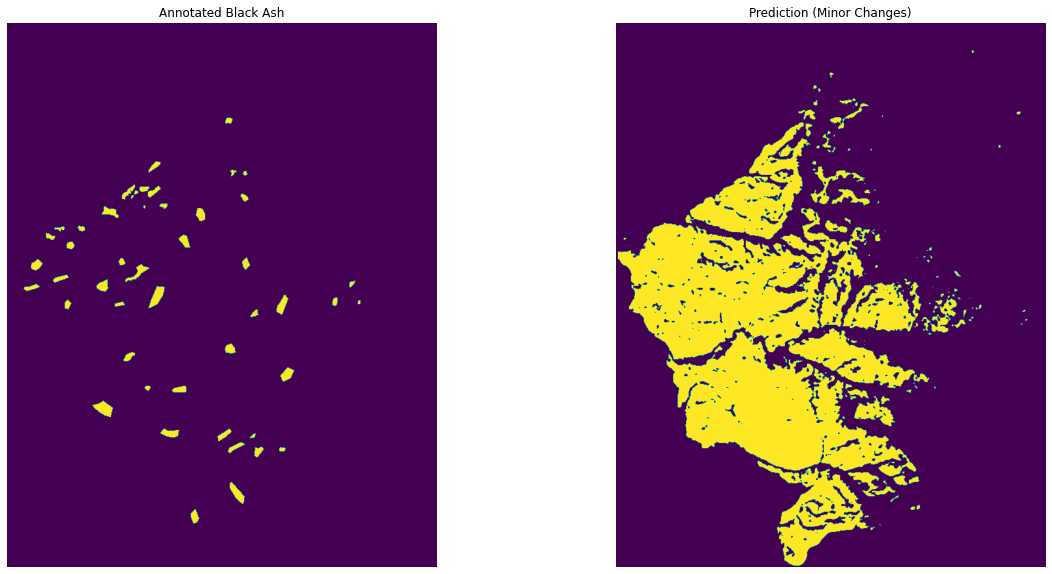

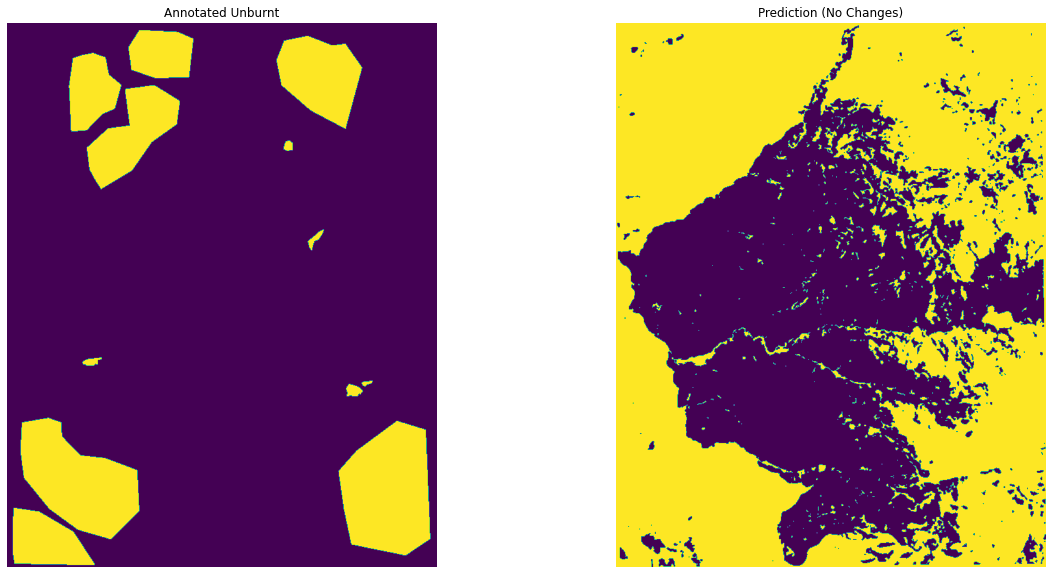

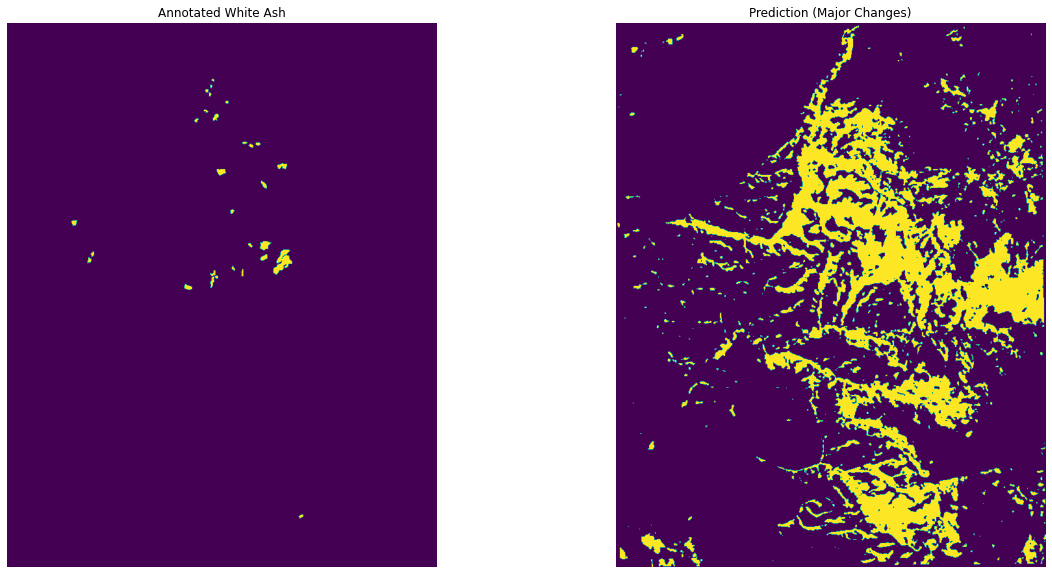

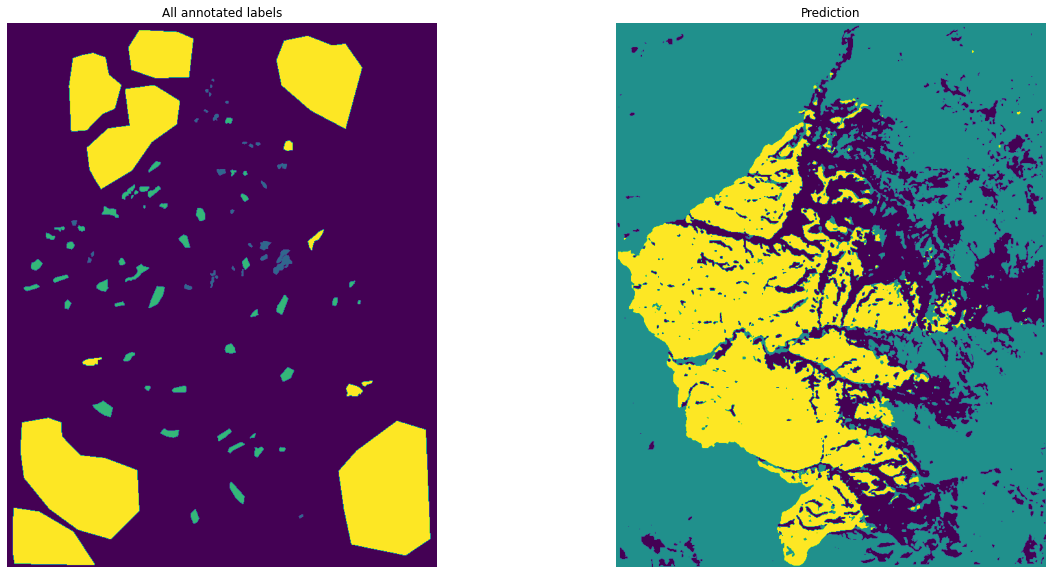

In [27]:
df_metrics, all_burnt_severity_arr = burnt_label_validation("/home/zbc123a/PS_CD_results/Mesa_PS_Stride8_3cluster_kmeans_vector_SR_20180726_20180815.tif",severity_labels,pred_dict,
                                                            out_dir="/home/zbc123a/wildfire/notebooks/Downstream/Figures/")

In [28]:
df_metrics

,Confusion_Matrix,F1_score,Precision,Recall,Accuracy
Unburnt,"[[44867, 44282], [3576, 85573]]",0.781474,0.658989,0.959887,0.731584
Black_Ash,"[[5279, 1598], [515, 6362]]",0.857586,0.799246,0.925113,0.846372
White_Ash,"[[1379, 358], [36, 1701]]",0.896207,0.826129,0.979275,0.886586


## PlanetScope + SimCLR + Distance Map

In [2]:
def generate_val_PRAUC(prediction, labels, out_dir = None, sampling = False):
    '''
    prediction: path of the prediction
    labels: path of the shapefile indicating the binary result
    sampling: default is false, if the ratio larger than 2 or smaller than 0.5, will be changed to True defautly
    '''
    rs_prediction = rio.open(prediction)
    rs_pred_prj = rs_prediction.crs.data['init']
    rs_pred_arr = rs_prediction.read().astype(np.float16)
    vector = gpd.read_file(labels)
    
    vector_rpj = vector.to_crs(rs_pred_prj)
    geom = [shapes for shapes in vector_rpj.geometry]
    rasterized_label = features.rasterize(geom,
                            out_shape = rs_prediction.shape,
                            fill = 0,
                            out = None,
                            transform = rs_prediction.transform,
                            all_touched = True,
                            default_value = 1,
                            dtype = None)

    # Plot raster
    fig, ax = plt.subplots(1,2, figsize = (20, 10))
    rioplt.show(rasterized_label, ax = ax[0])
    rioplt.show(rs_pred_arr, ax = ax[1])
    #image_hidden = ax[1].imshow(rs_pred_arr.reshape(2018, 1596), 
    #                     cmap='viridis', 
    #                     vmin=-30, 
    #                     vmax=30)
    ax[0].axis("off")
    ax[0].set_title("Label")
    ax[1].axis("off")
    ax[1].set_title("Prediction")
    # add colorbar using the now hidden image
    #fig.colorbar(image_hidden, ax=ax[1])
    if type(out_dir) == str:
        plt.savefig(out_dir,dpi=300)
    else:
        plt.show()
    #check the ratio of the postive vs negative labels
    num_pos_label = np.sum(rasterized_label)
    num_neg_label = np.sum(1-rasterized_label)
    ratio = num_pos_label/num_neg_label
    if ratio < 0.5 or ratio>2:
        sampling = True
    
    #randomly downsampling the major label to fit the minor label
    if sampling:
        
        if num_pos_label < num_neg_label: #number of negative labels > postive
            majority_row_col = np.argwhere(rasterized_label==0)
            minority_row_col = np.argwhere(rasterized_label==1)
            minor_num = num_pos_label
            major_num = num_neg_label
            major_label = 0
        else:
            majority_row_col = np.argwhere(rasterized_label==1)
            minority_row_col = np.argwhere(rasterized_label==0)
            minor_num = num_neg_label
            major_num = num_pos_label
            major_label = 1
        
        rand_idx = np.random.randint(0, high=major_num, size=minor_num, dtype=int)
        sampled_major_row_col = majority_row_col[rand_idx,:]

        df_label = pd.DataFrame(data = {"row": np.concatenate((sampled_major_row_col[:,0],minority_row_col[:,0]),axis = 0),
                                    "col":np.concatenate((sampled_major_row_col[:,1],minority_row_col[:,1]),axis = 0),
                                    "label": np.concatenate((np.full((minor_num,),major_label),np.full((minor_num,),1-major_label)),axis = 0)})
        pred_arr = rs_pred_arr[:,df_label.row.values,df_label.col.values].flatten()
        df_pred = pd.DataFrame(data = {"row": df_label.row.values,
                                        "col": df_label.col.values,
                                        "label": pred_arr})

    #no downsampling, comparing directly
    else:
        neg_label_loc = np.argwhere(rasterized_label==0)
        pos_label_loc = np.argwhere(rasterized_label==1)
        df_label =  pd.DataFrame(data = {"row": np.concatenate((neg_label_loc[:,0],pos_label_loc[:,0]),axis = 0),
                                "col":np.concatenate((neg_label_loc[:,1],pos_label_loc[:,1]),axis = 0),
                                "label": np.concatenate((np.full((neg_label_loc.shape[0],),0),np.full((pos_label_loc.shape[0],),1)),axis = 0)})
        pred_arr = rs_pred_arr[:,df_label.row.values,df_label.col.values].flatten()
        df_pred = pd.DataFrame(data = {"row": df_label.row.values,
                                        "col": df_label.col.values,
                                        "label": pred_arr})
    

    return df_label,df_pred

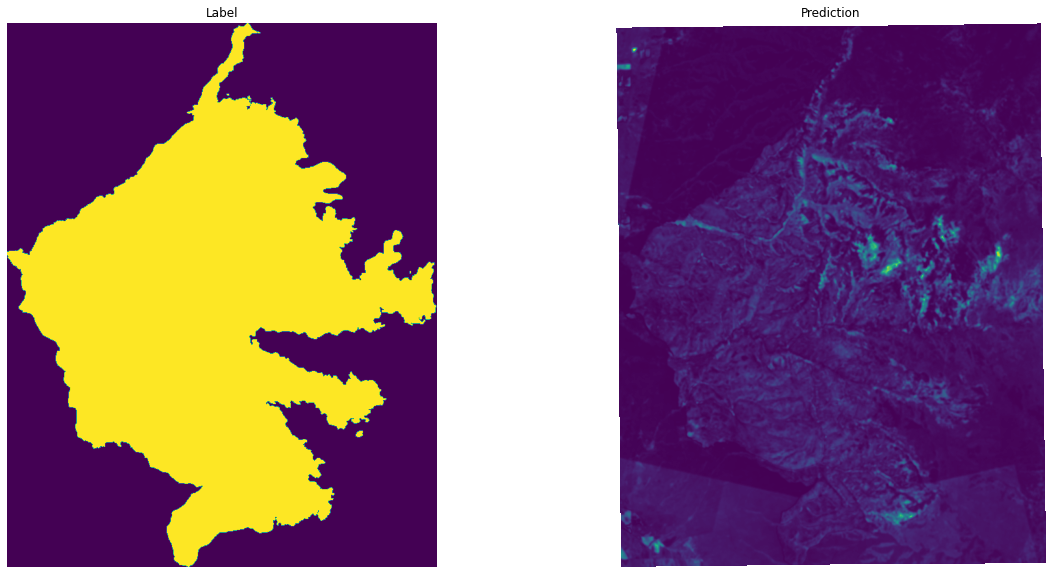

In [33]:
df_label,df_pred = generate_val_PRAUC("/home/zbc123a/PS_CD_results/Mesa_PS_M1_30th_Stride8_COSdist_scaled_SR_20180726_20180815.tif", 
                                        "/home/zbc123a/wildfire/notebooks/Downstream/Labels/Mesa_Shapefile/fire_parameter/MesaFire.shp", 
                                        #out_dir = "/home/zbc123a/wildfire/notebooks/Downstream/Figures/PS_SimCLR_COS.png",
                                        sampling = False)


In [34]:
#from vit
import numpy as np
true_changes = df_label.label.values
pred_change_scores = df_pred.label.values

print("We loaded", true_changes.shape, pred_change_scores.shape)

We loaded (554756,) (554756,)


In [35]:
from sklearn.metrics import precision_recall_curve, auc

def precision_recall(true_changes, pred_change_scores, mask=True):
    # convert to numpy arrays and mask invalid
    # After these lines the changes and scores are 1D
    if mask:
      invalid_masks = [c==2 for c in true_changes]
      true_changes = np.concatenate(
          [c[~m] for m,c in zip(invalid_masks, true_changes)],
          axis=0
      )
      pred_change_scores = np.concatenate(
          [c[~m] for m,c in zip(invalid_masks, pred_change_scores)],
          axis=0
      )
    else:
      # else just flatten
      true_changes = true_changes.flatten()
      pred_change_scores = pred_change_scores.flatten()

    precision, recall, thresholds = precision_recall_curve(
        true_changes,
        pred_change_scores
    )
    return precision, recall, thresholds
pred_change_scores[np.isnan(pred_change_scores)] = 0.0
precision, recall, thresholds = precision_recall(true_changes, pred_change_scores, mask=False)
area_under_precision_curve = auc(recall, precision)
print("AUPRC = ", area_under_precision_curve)

AUPRC =  0.7970898247182855


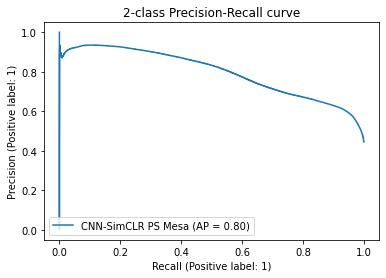

In [38]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(true_changes, pred_change_scores, name="CNN-SimCLR PS Mesa")
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.savefig("/home/zbc123a/wildfire/notebooks/Downstream/Figures/PS_SimCLR_COS_PRAUC.png",dpi=300)

## PlanetScope + PCA + Distance Map

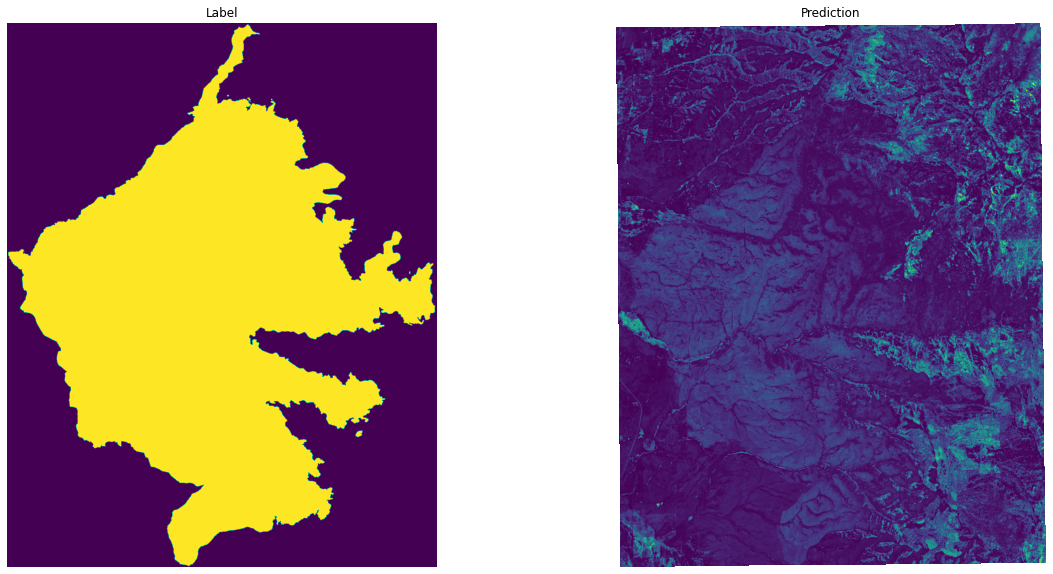

In [55]:
df_label,df_pred = generate_val_PRAUC("/home/zbc123a/CD_results/Mesa/S2_PCA_COSdist_scaled_CD.tif", 
                                    "/home/zbc123a/wildfire/notebooks/Downstream/Labels/Mesa_Shapefile/fire_parameter/MesaFire.shp", out_dir = "/home/zbc123a/wildfire/notebooks/Downstream/Figures/S2_PCA_COS.png",sampling = False)

In [56]:
#from vit
import numpy as np
true_changes = df_label.label.values
pred_change_scores = df_pred.label.values

print("We loaded", true_changes.shape, pred_change_scores.shape)

We loaded (3220728,) (3220728,)


In [57]:
print("min, max, mean:")
print(np.min(true_changes), np.max(true_changes), np.mean(true_changes))
print(np.min(pred_change_scores), np.max(pred_change_scores), np.mean(pred_change_scores))
print("label contains only:")
print(np.unique(true_changes))

min, max, mean:
0 1 0.43860549540352367
nan nan nan
label contains only:
[0 1]


In [58]:
from sklearn.metrics import precision_recall_curve, auc

def precision_recall(true_changes, pred_change_scores, mask=True):
    # convert to numpy arrays and mask invalid
    # After these lines the changes and scores are 1D
    if mask:
      invalid_masks = [c==2 for c in true_changes]
      true_changes = np.concatenate(
          [c[~m] for m,c in zip(invalid_masks, true_changes)],
          axis=0
      )
      pred_change_scores = np.concatenate(
          [c[~m] for m,c in zip(invalid_masks, pred_change_scores)],
          axis=0
      )
    else:
      # else just flatten
      true_changes = true_changes.flatten()
      pred_change_scores = pred_change_scores.flatten()

    precision, recall, thresholds = precision_recall_curve(
        true_changes,
        pred_change_scores
    )
    return precision, recall, thresholds
pred_change_scores[np.isnan(pred_change_scores)] = 0.0
precision, recall, thresholds = precision_recall(true_changes, pred_change_scores, mask=False)
area_under_precision_curve = auc(recall, precision)
print("AUPRC = ", area_under_precision_curve)

AUPRC =  0.4435798668963661


In [59]:
# Maximal score would be:
exact_prediction = true_changes.copy()
precision, recall, thresholds = precision_recall(true_changes, exact_prediction, mask=False)
area_under_precision_curve = auc(recall, precision)
print("AUPRC = ", area_under_precision_curve)

AUPRC =  1.0


In [60]:
# Minimal score would be:
random_prediction_absolutely_bad = np.random.randn(*true_changes.shape)

precision, recall, thresholds = precision_recall(true_changes, random_prediction_absolutely_bad, mask=False)
area_under_precision_curve = auc(recall, precision)
print("AUPRC = ", area_under_precision_curve)

AUPRC =  0.4386178797846791


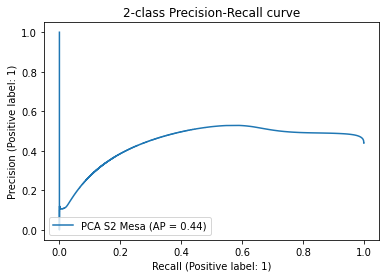

In [61]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(true_changes, pred_change_scores, name="PCA S2 Mesa")
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.savefig("/home/zbc123a/wildfire/notebooks/Downstream/Figures/S2_PCA_COS_PRAUC.png",dpi=300)